Stock Price Predictor Model using LSTM

In [40]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
import math

Here, we are taking APPLE stock for this prediction model.

In [41]:
ticker_symbol = "AAPL"
start_date = '2020-04-01'
end_date = '2025-07-20'

print(f"Downloading historical data for {ticker_symbol} from {start_date} to {end_date}...")
data = yf.download(ticker_symbol, start=start_date, end=end_date)

C:\Users\KIIT\AppData\Local\Temp\ipykernel_17124\3272669654.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [42]:
print(data.head())
print("\nData Info:")
data.info()

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-04-01  58.387234  60.280074  57.955831  59.742032  176218400
2020-04-02  59.361534  59.414854  57.415374  58.249097  165934000
2020-04-03  58.508415  59.548143  57.917053  58.845297  129880000
2020-04-06  63.612526  63.767633  60.440020  60.808406  201820400
2020-04-07  62.875767  65.849544  62.771553  65.631413  202887200

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1331 entries, 2020-04-01 to 2025-07-18
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, AAPL)   1331 non-null   float64
 1   (High, AAPL)    1331 non-null   float64
 2   (Low, AAPL)     1331 non-null   float64
 3   (Open, AAPL)    1331 non-null   float64
 4   (Volume, AAPL)  1331 non-null   int64  
dtypes: float64(4), i

In [43]:
data.tail()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-07-14,208.619995,210.910004,207.539993,209.929993,38840100
2025-07-15,209.110001,211.889999,208.919998,209.220001,42296300
2025-07-16,210.160004,212.399994,208.639999,210.300003,47490500
2025-07-17,210.020004,211.800003,209.589996,210.570007,48068100
2025-07-18,211.179993,211.789993,209.699997,210.869995,48974600


In [44]:
print("\nData Description:")
print(data.describe())


Data Description:
Price         Close         High          Low         Open        Volume
Ticker         AAPL         AAPL         AAPL         AAPL          AAPL
count   1331.000000  1331.000000  1331.000000  1331.000000  1.331000e+03
mean     162.208671   163.873045   160.365904   162.050455  8.220825e+07
std       41.211905    41.449868    40.897159    41.145959  4.304748e+07
min       58.387234    59.414854    57.415374    58.249097  2.323470e+07
25%      133.574585   135.115950   131.753933   133.330569  5.228960e+07
50%      161.912674   163.415532   159.450788   161.026223  7.111550e+07
75%      189.100639   190.488916   187.864248   188.847050  9.800295e+07
max      258.396667   259.474086   257.010028   257.568678  3.743368e+08


In [105]:
data.to_csv('Apple_Dataset')

In [ ]:
# Copy to add features without modifying the original downloaded data
df = data.copy()

In [48]:
df.columns = df.columns.droplevel(1)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [49]:
initial_rows_with_nan = df.isnull().sum(axis=1).astype(bool).sum()
df.dropna(inplace=True)
print(f"Dropped {initial_rows_with_nan} rows due to NaN values after feature engineering.")
print(f"DataFrame shape after feature engineering: {df.shape}")
print(df.head())

Dropped 0 rows due to NaN values after feature engineering.
DataFrame shape after feature engineering: (1331, 5)
Price            Open       High        Low      Close     Volume
Date                                                             
2020-04-01  59.742032  60.280074  57.955831  58.387234  176218400
2020-04-02  58.249097  59.414854  57.415374  59.361534  165934000
2020-04-03  58.845297  59.548143  57.917053  58.508415  129880000
2020-04-06  60.808406  63.767633  60.440020  63.612526  201820400
2020-04-07  65.631413  65.849544  62.771553  62.875767  202887200


In [50]:
features = df.columns.tolist()

In [51]:
cols = ['Close'] + [col for col in features if col != 'Close']
df = df[cols]

Scaling all features to a common range (0 - 1) helps model to perform better

In [52]:
scaler = MinMaxScaler(feature_range=(0,1))
# Fit and transform the entire DataFrame (all features)
scaled_data = scaler.fit_transform(df)
print("\nData scaled successfully.")
print(f"Shape of scaled_data: {scaled_data.shape}")


Data scaled successfully.
Shape of scaled_data: (1331, 5)


In [53]:
num_features = scaled_data.shape[1]
print(f"Number of features for LSTM input: {num_features}")

Number of features for LSTM input: 5


Time series data requires to be in chronological order. Random Split would introduce data leakage, This split allows to train on past data and test on unseen data.

In [77]:
train_size = int(len(scaled_data) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [78]:
print(f"\nTrain data size: {train_data.shape}")
print(f"Test data size: {test_data.shape}")


Train data size: (1064, 5)
Test data size: (267, 5)


 LSTMs process sequences. This function creates these sequences by defining a sliding window.

In [ ]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [80]:
time_step = 100 # Look-back period
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [81]:
print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")


Shape of X_train: (963, 100, 5), y_train: (963,)
Shape of X_test: (166, 100, 5), y_test: (166,)


A stacked LSTM architecture (multiple LSTM layers) allows the model to learn more complex temporal patterns.

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, num_features)))
model.add(Dropout(0.2)) # Added dropout
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2)) # Added dropout
model.add(LSTM(50)) # Last LSTM layer, return_sequences=False by default
model.add(Dropout(0.2)) # Added dropout
model.add(Dense(1)) # Output layer for predicting single 'Close' price

C:\Users\KIIT\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [83]:
model.compile(loss='mean_squared_error', optimizer='adam')
print("\nModel Summary:")
model.summary()


Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 50)        │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,651 (201.76 KB)

 Trainable params: 51,651 (201.76 KB)

 Non-trainable params: 0 (0.00 B)

In [84]:
print("\nTraining the model...")
# Using X_test, y_test as validation data during training
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)
print("Model training complete.")


Training the model...
Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0806 - val_loss: 0.0609
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - loss: 0.0084 - val_loss: 0.0296
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0064 - val_loss: 0.0150
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0047 - val_loss: 0.0106
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0040 - val_loss: 0.0050
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0038 - val_loss: 0.0062
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0036 - val_loss: 0.0064
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0038 - val_loss: 0.0063
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0037 - val_loss: 0.0056
Epoch 12/100
16/16 

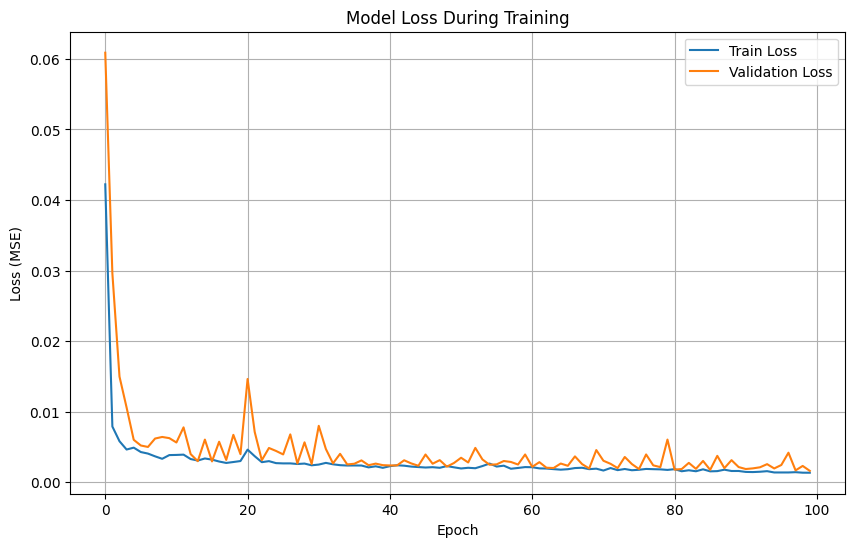

In [85]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
print("\nMaking predictions on train and test sets...")
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print("Predictions made.")



Making predictions on train and test sets...
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predictions made.


Inverse-transforms the train_predict (scaled predictions) back to the original stock price scale.

In [87]:
train_predict_full = np.zeros((len(train_predict), num_features))
train_predict_full[:,0] = train_predict.flatten() # Place 'Close' predictions in the first column
train_predict_inverse = scaler.inverse_transform(train_predict_full)[:,0]

Inverse-transforms the test_predict (scaled predictions) back to the original stock price scale.

In [88]:
test_predict_full = np.zeros((len(test_predict), num_features))
test_predict_full[:,0] = test_predict.flatten() # Place 'Close' predictions in the first column
test_predict_inverse = scaler.inverse_transform(test_predict_full)[:,0]

 Inverse-transforms the actual y_train and y_test values (which were also scaled) back to their original price scale.

In [89]:
y_train_inverse = scaler.inverse_transform(y_train.reshape(-1, 1) * np.ones((1, num_features)))[:,0]
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1) * np.ones((1, num_features)))[:,0]

Calculates the average of the squared differences between actual and predicted values.

In [90]:
train_rmse = math.sqrt(mean_squared_error(y_train_inverse, train_predict_inverse))
test_rmse = math.sqrt(mean_squared_error(y_test_inverse, test_predict_inverse))
print(f"\nTrain RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")


Train RMSE: 4.7390
Test RMSE: 8.0626


In [91]:
plot_data = df['Close'].values.reshape(-1, 1) # Only plot the original Close prices
trainPredictPlot = np.empty_like(plot_data)
trainPredictPlot[:, :] = np.nan
# Adjust index for train predictions
trainPredictPlot[time_step:len(train_predict_inverse) + time_step, :] = train_predict_inverse.reshape(-1, 1)

In [92]:
testPredictPlot = np.empty_like(plot_data)
testPredictPlot[:, :] = np.nan
# Adjust index for test predictions (after train_size and look_back for test set)
# The test data starts at train_size, and then we have time_step for the lookback window
testPredictPlot[len(train_predict_inverse) + (time_step * 2) + 1:len(plot_data) - 1, :] = test_predict_inverse.reshape(-1, 1)

 Plot showing the original 'Close' prices, the model's predictions on the training data, and the model's predictions on the test data.

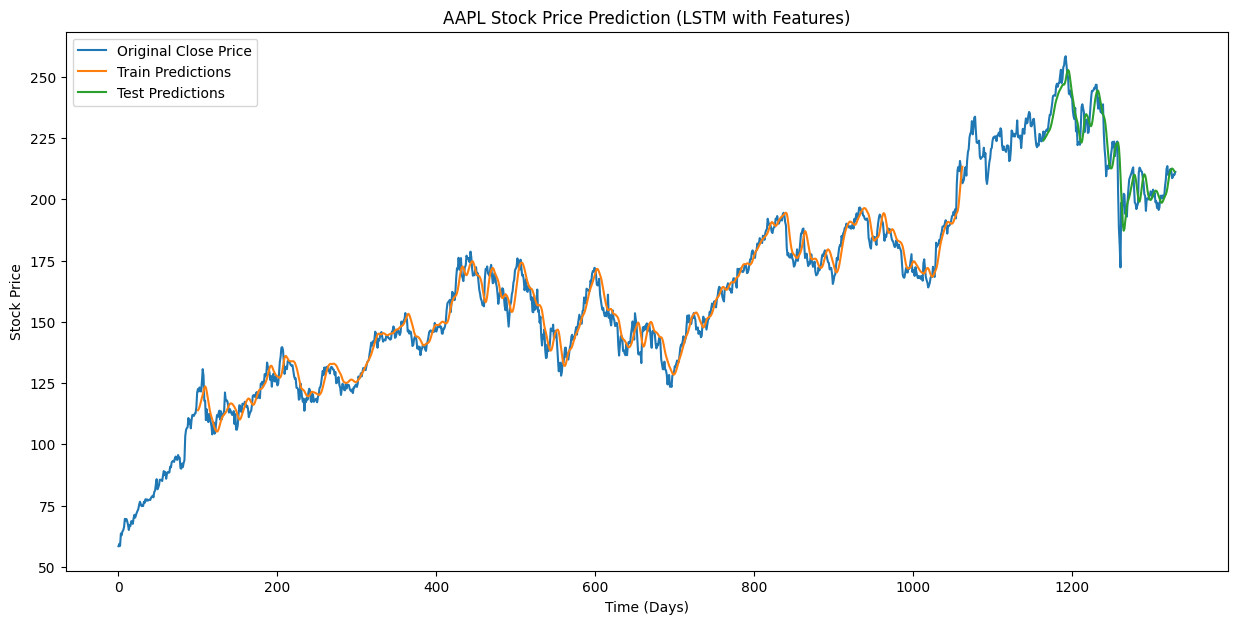

In [93]:
plt.figure(figsize=(15, 7))
plt.plot(scaler.inverse_transform(scaled_data)[:,0], label='Original Close Price') # Plot original Close price
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.title(f'{ticker_symbol} Stock Price Prediction (LSTM with Features)')
plt.xlabel('Time (Days)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [94]:
last_sequence = test_data[-time_step:]
x_input = last_sequence.reshape(1, time_step, num_features)


In [95]:
lst_output = []
n_future_steps = 20 

In [96]:
last_known_features_template = test_data[-1, :].copy()
print(f"\nPredicting next {n_future_steps} days...")
for i in range(n_future_steps):
    # Predict the next 'Close' price
    yhat_scaled = model.predict(x_input, verbose=0)

    # Create a full feature array for the predicted next day
    # Assume other features are the same as the last known day, only update 'Close'
    next_day_features_scaled = last_known_features_template.copy()
    next_day_features_scaled[0] = yhat_scaled[0, 0] # Update 'Close' price

    # Append the predicted full feature row to the sequence
    new_sequence = np.append(x_input[:, 1:, :], next_day_features_scaled.reshape(1, 1, num_features), axis=1)
    x_input = new_sequence # Update the input sequence for the next prediction

    # Store the predicted 'Close' price (scaled)
    lst_output.append(yhat_scaled[0].tolist())


Predicting next 20 days...


In [97]:
predicted_future_full = np.zeros((len(lst_output), num_features))
predicted_future_full[:,0] = np.array(lst_output).flatten()
predicted_future_inverse = scaler.inverse_transform(predicted_future_full)[:,0]

In [98]:
print("\nPredicted future 'Close' prices (next 20 days):")
for i, price in enumerate(predicted_future_inverse):
    print(f"Day {i+1}: {price:.2f}")


Predicted future 'Close' prices (next 20 days):
Day 1: 210.46
Day 2: 210.25
Day 3: 210.14
Day 4: 210.10
Day 5: 210.12
Day 6: 210.17
Day 7: 210.24
Day 8: 210.32
Day 9: 210.40
Day 10: 210.50
Day 11: 210.59
Day 12: 210.68
Day 13: 210.77
Day 14: 210.85
Day 15: 210.93
Day 16: 211.00
Day 17: 211.06
Day 18: 211.12
Day 19: 211.17
Day 20: 211.22


In [99]:
original_dates = df.index
# Dates for future predictions
last_original_date = original_dates[-1]
future_dates = pd.date_range(start=last_original_date + pd.Timedelta(days=1), periods=n_future_steps, freq='B')

In [100]:
combined_data = np.concatenate((df['Close'].values, predicted_future_inverse)).flatten()
combined_dates = original_dates.append(future_dates)

 Showing a zoomed-in view of recent history alongside the future forecast.

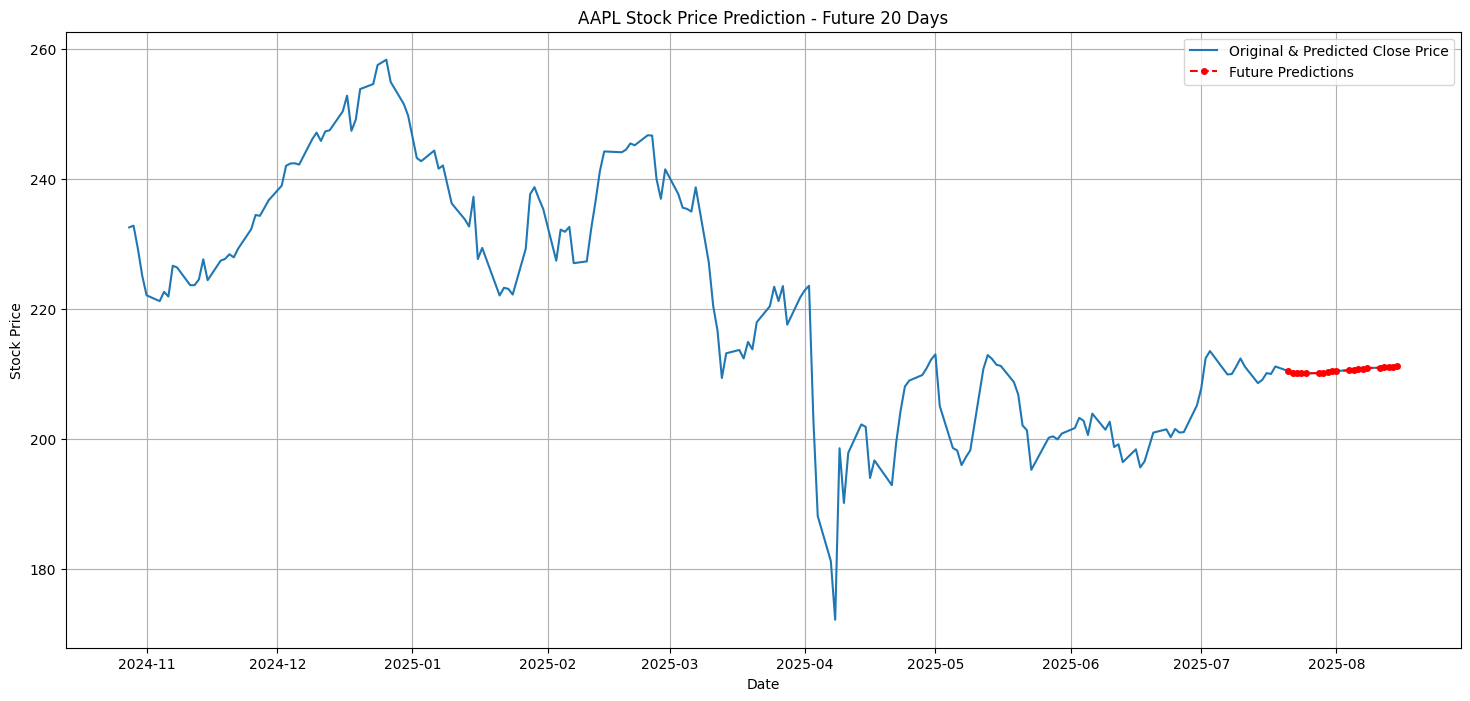

In [101]:
plt.figure(figsize=(18, 8))
plt.plot(combined_dates[-200:], combined_data[-200:], label='Original & Predicted Close Price') # Show last 200 days for context
plt.plot(future_dates, predicted_future_inverse, color='red', linestyle='--', marker='o', markersize=4, label='Future Predictions')
plt.title(f'{ticker_symbol} Stock Price Prediction - Future {n_future_steps} Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [103]:
ticker_symbol = 'AAPL'
start_date = '2025-07-20'
end_date = '2025-07-29'

print(f"Downloading historical data for {ticker_symbol} from {start_date} to {end_date}...")
new_data = yf.download(ticker_symbol, start=start_date, end=end_date)


C:\Users\KIIT\AppData\Local\Temp\ipykernel_17124\1961452244.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  new_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [104]:
new_data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-07-21,212.479996,215.779999,211.630005,212.100006,51377400
2025-07-22,214.399994,214.949997,212.229996,213.139999,46404100
2025-07-23,214.149994,215.149994,212.410004,215.000000,46989300
2025-07-24,213.759995,215.690002,213.529999,213.899994,46022600
2025-07-25,213.880005,215.240005,213.399994,214.699997,40268800
